In [2]:
# import all needed packages 
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt   
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from numpy import absolute, mean, std
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
df = pd.read_excel("E Commerce Dataset.xlsx", sheet_name=1)

df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


### **Remove unnecessary columns**
- Unnecessary information are noise for our model. We should remove them.
- `CustomerID` is just a unique identifier to each user and has nothing to do with predicting if user churns or not. Let's drop it

In [5]:
df = df.drop(['CustomerID'], axis=1)

### **Duplicate rows**

- Check if we have duplicate rows. Data set shouldn't have duplicate rows as they could bias the model
- The data set doesn't have any duplicate rows

In [8]:
df.duplicated().any()

True

### **Define Numerical and Categorical columns**
- It's important to define Numerical and Categorical columns to be able to understand how can we handle NULL values
- Handling NULL values for Numerical and Categorical columns is quite different 

In [9]:
cat_columns = df.select_dtypes(include="O").columns
num_columns = []
for col in df.columns:
    if col not in cat_columns:
        num_columns.append(col)
        
print("Numerical columns: ", num_columns)
print("Categorical columns: ", cat_columns)

Numerical columns:  ['Churn', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
Categorical columns:  Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus'],
      dtype='object')


Let's look into the unique values of each Categorical column. It might help us to clean data up a bit.

In [10]:
for col in cat_columns:
    print(col, df[col].unique())

PreferredLoginDevice ['Mobile Phone' 'Phone' 'Computer']
PreferredPaymentMode ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
Gender ['Female' 'Male']
PreferedOrderCat ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
MaritalStatus ['Single' 'Divorced' 'Married']


- In `PreferredLoginDevice`, `Mobile Phone` and `Phone` can be merged into one category
- In `PreferredPaymentMode`, `Credit Card` and `CC` can be merged into one category
- In `PreferedOrderCat`, `Mobile Phone` and `Phone` can be merged into one category

Let's do it!


In [11]:
df.replace(['Mobile Phone', 'Credit Card', 'Mobile Phone'], ['Phone', 'CC', 'Mobile'], inplace=True)

### **NULL Values**
- NULL values could make our model flaky due to values absence
- The following columns have some NULL values

```[Tenure, WarehouseToHome, HourSpendOnApp, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder]```

- All of these columns are Numerical columns. So, we ca replace NULL values with the mean value of the relevant column. We can do this as part of the pipeline right before training the model. Stay tuned 😉


In [12]:
df.isna().sum()

Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

### **Handling Categorical Variables**
- In our data set, the following columns are categories: ```['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender','PreferedOrderCat', 'MaritalStatus']```
- As part of our pipeline, we have to use `OneHotEncoder` to encode the categories

### **Data Standardisation**
- It's a way to transform data points to have mean of the values is 0 and the standard deviation is 1
- This step is needed because different data columns have different scales

Aaaaaaand, now it's time to start training & testing different models and getting into the experiment phase. But before that, let's have a look into `train_and_test` method first. 
`train_and_test` method takes:
- `X` --> data independent variables
- `y` --> data dependent variable (Churn or Not in our case)
- `classifier` --> which is classification model (i.e. Logistic, Decision Tree, ...etc)

`train_and_test` method does:
- Encode categorical columns using OneHotEncoder
- Fill numerical NULL values with the mean value of the relevant column (aka Imputation)
- Create the data transformer
- Create the model pipeline given transformer and classifier
- Prpeare training and testing data
- Fit the model using the tarining data
- Calculate accuracy and confusion matix for training and testing data

Simply, `train_and_test` method does everything for us! 

In [14]:
def train_and_test (X, y, classifier, test_size, enable_print = True): 
    # get categorical and numerical columns
    cat_columns = X.select_dtypes(include="O").columns
    num_columns = []
    for col in X.columns:
        if col not in cat_columns:
            num_columns.append(col)
    
    # encode categorical columns using OneHotEncoder
    categorical_col = Pipeline(steps=[
          ('encoding', OneHotEncoder())
      ])
    
    # fill numerical NULL values with the mean value of the relevant column
    numerical_col = Pipeline(steps=[
          ('imputer', SimpleImputer(strategy="mean")),
          ('scaler', StandardScaler())
      ])
    
    # transform data
    transformer = ColumnTransformer(transformers=[
        ('categorical_col', categorical_col, cat_columns),    
        ('numerical_col', numerical_col, num_columns)
      ])
    
    # create model
    model = Pipeline([
          ('transformer', transformer),
          ('classifier', classifier)
      ])

    # prpeare training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # fit the model
    model.fit(X_train, y_train)
    
    # calculate the training data accuracy and confusion matix
    pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, pred)
    matrix = confusion_matrix(y_train, pred)
    if enable_print:
        print('Train confusion matrix:\n', matrix)
        print('Train accuracy: ', accuracy * 100, '%')

    # calculate the testing data accuracy and confusion matix
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    matrix = confusion_matrix(y_test, pred)
    if enable_print: 
        print('Test confusion matrix:\n', matrix)
        print('Test accuracy: ', accuracy * 100, '%')
        print("=====================================================================")
  
    return accuracy

In [15]:
# prepare X and y
X = df.drop(columns=["Churn"])
y = df["Churn"]
test_size = 0.2

# **Training the model**

Next, we will try different Classifiers and compare accuracies using cross validation.

Let's kepp it simple stupid at the beginning. We can go with the simplest Classifier, Logistic Classifier

In [16]:
print("========================== Logistic Classifier ==========================")
model = train_and_test(X, y, LogisticRegression(solver='liblinear'), test_size)

========================== Logistic Classifier ==========================
Train confusion matrix:
 [[3623  118]
 [ 377  386]]
Train accuracy:  89.00976909413855 %
Test confusion matrix:
 [[925  16]
 [ 81 104]]
Test accuracy:  91.3854351687389 %


Really good that Logistic Classifier gives around 91% accuracy for test data. Let's increase the model complexity, time to test with **Decision Tree Classifier**

In [17]:
print("========================== DecisionTreeClassifier ==========================")
model = train_and_test(X, y, DecisionTreeClassifier(random_state=42), test_size)

========================== DecisionTreeClassifier ==========================
Train confusion matrix:
 [[3741    0]
 [   0  763]]
Train accuracy:  100.0 %
Test confusion matrix:
 [[928  13]
 [ 17 168]]
Test accuracy:  97.33570159857904 %


We can see quite huge jump in both train and test accuracies. However, it might be the overfitting problem is here because Bias is zero and Variance is quite high compared to Bias.


One solution here is to use an ensemble boosting algorithm that can help to decrease Variance, XGB Classifier.

In [18]:
print("========================== XGBClassifier ==========================")
model = train_and_test(X, y, XGBClassifier(), test_size)

========================== XGBClassifier ==========================
Train confusion matrix:
 [[3741    0]
 [   0  763]]
Train accuracy:  100.0 %
Test confusion matrix:
 [[938   3]
 [ 16 169]]
Test accuracy:  98.3126110124334 %


Cool, XGBClassifier successded to improve Test accuracy by around 1%. Next step to improve the accuracy is to do XGB Classifier Hypertuning 


# **Hypertuning XGBClassifier params**

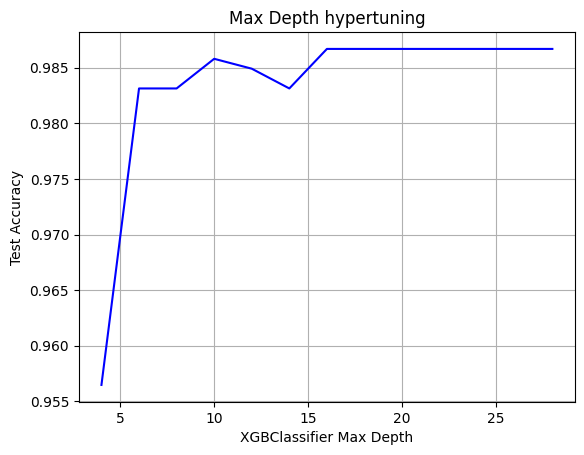

In [19]:
# Tree max depth hypertuning
max_depth = []
accuracies = []

for i in range(4, 30, 2):
    grid = {'max_depth': i}
    clf = XGBClassifier()
    clf.set_params(**grid)
    accuracy = train_and_test(X, y, clf, test_size, False)
    
    max_depth.append(i)
    accuracies.append(accuracy)

plt.title("Max Depth hypertuning")
plt.xlabel("XGBClassifier Max Depth")
plt.ylabel("Test Accuracy")
plt.plot(max_depth, accuracies, 'b')
plt.grid()

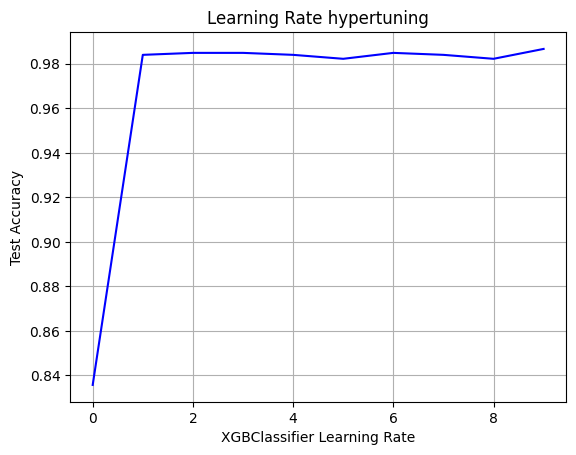

In [20]:
# Learning rate hypertuning
learning_rates = []
accuracies = []

for i in range(0, 10, 1):
    eta = i / 10
    grid = {'max_depth': 12, 'eta': eta}
    clf = XGBClassifier()
    clf.set_params(**grid)
    accuracy = train_and_test(X, y, clf, test_size, False)
    
    learning_rates.append(i)
    accuracies.append(accuracy)

plt.title("Learning Rate hypertuning")
plt.xlabel("XGBClassifier Learning Rate")
plt.ylabel("Test Accuracy")
plt.plot(learning_rates, accuracies, 'b')
plt.grid()

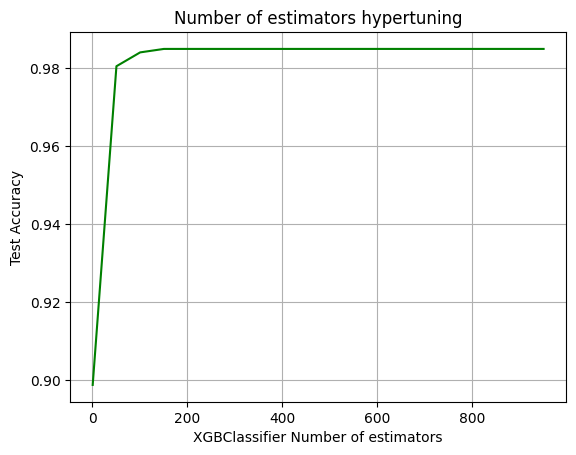

In [21]:
# Number of estimators hypertuning
n_estimators = []
accuracies = []

for i in range(1, 1000, 50):
    grid = {'max_depth': 12, 'eta': 0.4, 'n_estimators': i}
    clf = XGBClassifier()
    clf.set_params(**grid)
    accuracy = train_and_test(X, y, clf, test_size, False)
    
    n_estimators.append(i)
    accuracies.append(accuracy)

plt.title("Number of estimators hypertuning")
plt.xlabel("XGBClassifier Number of estimators")
plt.ylabel("Test Accuracy")
plt.plot(n_estimators, accuracies, 'g')
plt.grid()


After hypertuning XGB Classifier params, we use the optimal values:
* max_depth: 16
* eta: 0.4
* n_estimators: 400

Let's do final model with the hypertuned params.

In [22]:
print("========================== XGBClassifier with hypertuned params ==========================")
grid = {'max_depth': 16, 'eta': 0.4, 'alpha': 0, 'lambda': 1, 'n_estimators': 400}
clf = XGBClassifier()
clf.set_params(**grid)
accuracy = train_and_test(X, y, clf, test_size)

========================== XGBClassifier with hypertuned params ==========================
Train confusion matrix:
 [[3741    0]
 [   0  763]]
Train accuracy:  100.0 %
Test confusion matrix:
 [[940   1]
 [ 12 173]]
Test accuracy:  98.84547069271758 %


In [23]:
import pickle

# Save the model to a file
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(model, f)
